# Excel Cleaner — Notebook-версія (частина 1)

> Цей ноутбук — notebook-версія скрипта `parse_excel_files_01.py` (перша частина плану).  
> **Мета:** пакетно обробити Excel-звіти та зберегти “очищені” файли.

## Що робить скрипт
- Вхідні `.xlsx` файли мають лежати у папці **`ACTIVE_REPORTS/`**
- Результат зберігається у **`PROCESSED_REPORTS/`**
- Якщо файл не обробився — його копія потрапляє в **`FAILED_REPORTS/`**
- Детальний лог пишеться у файл **`excel_cleaner.log`**

---

## Як запускати в Google Colab
1. Зліва **Files** → **Upload** і завантаж `.xlsx` файли в папку `ACTIVE_REPORTS/` (або просто в корінь і перенеси).
2. Запусти клітинки з кодом **зверху вниз**.
3. Після виконання перевір папки `PROCESSED_REPORTS/` та `FAILED_REPORTS/`.

Дата збірки ноутбука: **2025-12-25**


## Опис (з коментаря у файлі)

Скрипт очищення Excel-звітів (палетні/складські таблиці) з використанням openpyxl.

✅ В консолі: короткий 1-рядковий вивід для кожного оброблюваного файлу
✅ Детальний лог: у файлі excel_cleaner.log

Основна ідея:
- Вхідні файли (.xlsx) лежать у ACTIVE_REPORTS/
- Результат зберігається у PROCESSED_REPORTS/
- Якщо файл не обробився — його копія потрапляє в FAILED_REPORTS/

Що робимо з кожним файлом:
1) Знаходимо рядок заголовків (необов'язкого третій, динамічно):
   - беремо стовбчик A;
   - шукаємо перший рядок, де значення "містить" один із синонімів слова "артикул" (Symbol і т.д.)
2) Знаходимо колонки: Symbol / Netto / Brutto / Total
3) Визначаємо "палетні" колонки між Brutto і Total
4) Перераховуємо TOTAL як суму палетних колонок
5) Пропускаємо рядки, де і computed_total, і original_total == 0
6) Підсвічуємо червоним рядки, де computed_total != original_total

## 1) Підготовка середовища

In [12]:
# Якщо запускаєш у Colab/ноутбуці — створимо потрібні папки.
import os

ACTIVE_REPORTS_DIR = "ACTIVE_REPORTS"
PROCESSED_REPORTS_DIR = "PROCESSED_REPORTS"
FAILED_REPORTS_DIR = "FAILED_REPORTS"

for d in (ACTIVE_REPORTS_DIR, PROCESSED_REPORTS_DIR, FAILED_REPORTS_DIR):
    os.makedirs(d, exist_ok=True)

print("✅ Папки готові:", ACTIVE_REPORTS_DIR, PROCESSED_REPORTS_DIR, FAILED_REPORTS_DIR)


✅ Папки готові: ACTIVE_REPORTS PROCESSED_REPORTS FAILED_REPORTS


### Завантаження файлів у Colab (опціонально)
Якщо ти в Colab і хочеш швидко завантажити файли через діалог, можеш використати:

```python
from google.colab import files
uploaded = files.upload()  # обери .xlsx файли
```

Потім перетягни їх у `ACTIVE_REPORTS/` через панель Files.


## 2) Імпорти, константи та допоміжні функції

Нижче — код зі скрипта, розбитий на логічні блоки.

### 2.1 Імпорти

In [13]:
from __future__ import annotations

import logging
import os
import re
import shutil
from dataclasses import dataclass
from typing import Dict, List, Optional, Sequence, Tuple

import openpyxl
from openpyxl.styles import PatternFill
from openpyxl.utils import get_column_letter
from openpyxl.workbook import Workbook

### 2.2 Налаштування, логер, структури та хелпери

In [14]:
from __future__ import annotations

import logging
import os
import re
import shutil
from dataclasses import dataclass
from typing import Dict, List, Optional, Sequence, Tuple

import openpyxl
from openpyxl.styles import PatternFill
from openpyxl.utils import get_column_letter
from openpyxl.workbook import Workbook


# =========================
# НАЛАШТУВАННЯ ПАПОК
# =========================
ACTIVE_REPORTS_DIR = "ACTIVE_REPORTS"
PROCESSED_REPORTS_DIR = "PROCESSED_REPORTS"
FAILED_REPORTS_DIR = "FAILED_REPORTS"

# =========================
# НАЛАШТУВАННЯ ЛИСТА / ФОРМАТУ
# =========================
PREFERRED_SHEET_NAME = "Arkusz1"

# Допуск для порівняння float (щоб не ловити мікро-похибки)
TOL = 1e-6

# Скільки перших рядків скануємо в колонці A, щоб знайти заголовок
HEADER_SCAN_LIMIT = 80

# Файл логів (детальний вивід піде сюди)
LOG_FILE = "excel_cleaner.log"

# Ширина стовпчика з іменем файлу у виводі консолі
FILENAME_COL_WIDTH = 64


# =========================
# СИНОНІМИ НАЗВ КОЛОНОК (СИРІ ВАРІАНТИ)
# =========================
# Роблю "м'який" пошук (contains), тому:
# - нормалізую текст (lower, без пунктуації, пробіли)
# - прибираю дублікати після нормалізації
# - сортую ключі за довжиною (довші — раніше), щоб зменшити шум
SYMBOL_NAMES_RAW = [
    "symbol",
    "артикул",
    "арт",
    "арт.",
    "кат номер",
    "кат. номер",
    "каталоговый номер",
    "каталожный номер",
    "код товара",
    "код",
    "sku",
    "item",
    "item no",
    "item no.",
    "item number",
]

NETTO_NAMES_RAW = [
    "waga netto",
    "netto",
    "вага нетто",
    "вес нетто",
    "net weight",
    "waga netto [kg]",
    "waga netto kg",
    "нетто"
]

BRUTTO_NAMES_RAW = [
    "waga brutto",
    "brutto",
    "вага брутто",
    "вес брутто",
    "gross weight",
    "waga brutto [kg]",
    "waga brutto kg",
    "брутто"
]

TOTAL_NAMES_RAW = [
    "total",
    "всього",
    "всего",
    "итого",
    "разом",
    "sum",
    "suma",
    "suma razem",
    "grand total",
]


# =========================
# ЛОГЕР
# =========================
def setup_logger() -> logging.Logger:
    """
    Налаштовує логер, який пише детальний лог у файл.

    Не виводимо деталі в консолі, щоб не захаращувати вивід.
    (В консолі лише короткий print у main()).
    """
    logger = logging.getLogger("excel_cleaner")
    logger.setLevel(logging.DEBUG)

    # Щоб не дублювати хендлери при повторних запусках в інтерактивному режимі
    if logger.handlers:
        return logger

    formatter = logging.Formatter(
        fmt="%(asctime)s | %(levelname)s | %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
    )

    file_handler = logging.FileHandler(LOG_FILE, encoding="utf-8")
    file_handler.setLevel(logging.DEBUG)
    file_handler.setFormatter(formatter)

    logger.addHandler(file_handler)
    return logger


LOGGER = setup_logger()


# =========================
# ДОПОМІЖНІ СТРУКТУРИ
# =========================
@dataclass
class DetectResult:
    """
    Результат детекції структури таблиці:
    - де заголовок (header_row)
    - які колонки відповідають основним полям
    - які колонки вважаються "палетними"
    """
    header_row: int
    col_symbol: int
    col_netto: int
    col_brutto: int
    col_total: int
    pallet_cols: List[int]


# =========================
# ДОПОМІЖНІ ФУНКЦІЇ
# =========================
def ensure_dirs() -> None:
    """Створює потрібні папки, якщо вони не існують."""
    os.makedirs(ACTIVE_REPORTS_DIR, exist_ok=True)
    os.makedirs(PROCESSED_REPORTS_DIR, exist_ok=True)
    os.makedirs(FAILED_REPORTS_DIR, exist_ok=True)


def pick_sheet_name(wb: openpyxl.Workbook) -> str:
    """
    Обирає лист для обробки:
    - якщо існує Arkusz1 — беремо його
    - інакше беремо перший лист
    """
    return PREFERRED_SHEET_NAME if PREFERRED_SHEET_NAME in wb.sheetnames else wb.sheetnames[0]


def unmerge_all(ws: openpyxl.worksheet.worksheet.Worksheet) -> None:
    """
    'Розмерджує' всі об’єднані комірки.

    Чому це важливо:
    - Об’єднані клітинки часто приховують заголовки колонок.
    - Після unmerge ми копіюємо значення верхньої-лівої клітинки
      в усі клітинки колишнього merged-блоку.
    """
    for merged_range in list(ws.merged_cells.ranges):
        min_r, min_c, max_r, max_c = merged_range.bounds
        top_left_value = ws.cell(min_r, min_c).value

        ws.unmerge_cells(str(merged_range))

        for r in range(min_r, max_r + 1):
            for c in range(min_c, max_c + 1):
                ws.cell(r, c).value = top_left_value


def is_col_hidden(ws: openpyxl.worksheet.worksheet.Worksheet, col_idx: int) -> bool:
    """Повертає True, якщо колонка прихована."""
    dim = ws.column_dimensions.get(get_column_letter(col_idx))
    return bool(dim.hidden) if dim else False


def normalize_text(value: object) -> str:
    """
    Нормалізує текст для більш стабільного порівняння.

    Робимо:
    - None -> ""
    - lower-case
    - прибираємо пунктуацію (залишаємо літери/цифри/пробіли)
    - стискаємо пробіли
    """
    if value is None:
        return ""
    text = str(value).replace("\u00a0", " ").strip().lower()
    text = re.sub(r"[^0-9a-zа-яіїєёґ\s]+", " ", text, flags=re.IGNORECASE)
    text = " ".join(text.split())
    return text


def build_keys(raw: Sequence[str]) -> List[str]:
    """
    Готує список ключів для пошуку:
    - нормалізує
    - прибирає дублікати після нормалізації
    - сортує за довжиною (довші ключі першими)
    """
    uniq = {normalize_text(x) for x in raw if normalize_text(x)}
    return sorted(uniq, key=len, reverse=True)


SYMBOL_KEYS = build_keys(SYMBOL_NAMES_RAW)
NETTO_KEYS = build_keys(NETTO_NAMES_RAW)
BRUTTO_KEYS = build_keys(BRUTTO_NAMES_RAW)
TOTAL_KEYS = build_keys(TOTAL_NAMES_RAW)

REQUIRED_ALL_KEYS = set(SYMBOL_KEYS) | set(NETTO_KEYS) | set(BRUTTO_KEYS) | set(TOTAL_KEYS)


def contains_any_key(text: str, keys: Sequence[str]) -> bool:
    """
    Перевіряє "м’яку" умову: чи містить text хоч один key (substring match).
    text та keys мають бути нормалізовані.
    """
    return bool(text) and any(k in text for k in keys)


def find_header_row_by_symbol(
    ws: openpyxl.worksheet.worksheet.Worksheet,
    scan_limit: int = HEADER_SCAN_LIMIT,
    header_col: int = 1,
) -> Optional[int]:
    """
    Знаходить рядок заголовків за правилом:
    - скануємо колонку A (header_col=1)
    - знаходимо перший рядок, де значення містить один із SYMBOL_KEYS

    Повертає:
        номер рядка або None
    """
    max_row = min(ws.max_row, scan_limit)
    for r in range(1, max_row + 1):
        cell_text = normalize_text(ws.cell(r, header_col).value)
        if contains_any_key(cell_text, SYMBOL_KEYS):
            return r
    return None


def build_header_map(
    ws: openpyxl.worksheet.worksheet.Worksheet,
    header_row: int,
) -> Dict[int, str]:
    """
    Формує мапу заголовків:
    {номер_колонки: нормалізований_заголовок}
    """
    header_map: Dict[int, str] = {}
    for c in range(1, ws.max_column + 1):
        h = normalize_text(ws.cell(header_row, c).value)
        if h:
            header_map[c] = h
    return header_map


def find_first_column_by_keys(header_map: Dict[int, str], keys: Sequence[str]) -> Optional[int]:
    """Повертає першу колонку, заголовок якої містить хоча б один key."""
    for col_idx, header_text in header_map.items():
        if contains_any_key(header_text, keys):
            return col_idx
    return None


def safe_copy_to_failed(path: str) -> str:
    """Копіює файл у FAILED_REPORTS_DIR (для ручної перевірки)."""
    dst = os.path.join(FAILED_REPORTS_DIR, os.path.basename(path))
    shutil.copy2(path, dst)
    return dst


def as_number(value: object) -> float:
    """Перетворює число (int/float) у float, все інше — 0.0."""
    if isinstance(value, (int, float)):
        return float(value)
    return 0.0

### 2.3 Детекція колонок (заголовки, палетні колонки, TOTAL)

In [15]:
def detect_columns(ws_struct, ws_val) -> DetectResult:
    """
    Детектує:
    - рядок заголовків
    - колонки symbol/netto/brutto/total
    - "палетні" колонки між brutto і total

    Повертає DetectResult або кидає ValueError.
    """
    header_row = find_header_row_by_symbol(ws_struct)
    if header_row is None:
        raise ValueError(
            "Не знайдено рядок заголовків: у колонці A немає ключів артикулу "
            f"в межах перших {HEADER_SCAN_LIMIT} рядків."
        )

    header_map = build_header_map(ws_struct, header_row)

    col_symbol = find_first_column_by_keys(header_map, SYMBOL_KEYS)
    col_netto = find_first_column_by_keys(header_map, NETTO_KEYS)
    col_brutto = find_first_column_by_keys(header_map, BRUTTO_KEYS)
    col_total = find_first_column_by_keys(header_map, TOTAL_KEYS)

    if None in (col_symbol, col_netto, col_brutto, col_total):
        raise ValueError(
            "Не знайдено всі обов'язкові колонки. "
            f"symbol={col_symbol}, netto={col_netto}, brutto={col_brutto}, total={col_total}, "
            f"header_row={header_row}"
        )

    left, right = sorted([col_brutto, col_total])

    # Палетні колонки: між brutto і total, не приховані, не системні
    pallet_cols: List[int] = []
    for c in range(left + 1, right):
        if is_col_hidden(ws_struct, c):
            continue
        if c not in header_map:
            continue
        if contains_any_key(header_map[c], list(REQUIRED_ALL_KEYS)):
            continue
        pallet_cols.append(c)

    if not pallet_cols:
        raise ValueError(
            f"Не знайдено палетні колонки між brutto(col={col_brutto}) і total(col={col_total})."
        )

    return DetectResult(
        header_row=header_row,
        col_symbol=col_symbol,
        col_netto=col_netto,
        col_brutto=col_brutto,
        col_total=col_total,
        pallet_cols=pallet_cols,
    )


# =========================
# ОСНОВНА ФУНКЦІЯ ОБРОБКИ ОДНОГО ФАЙЛУ
# =========================

## 3) Основна функція обробки одного файлу

In [16]:
def clean_one_file(input_path: str, output_path: str) -> Tuple[int, int]:
    """
    Очищує один Excel-файл і зберігає результат.

    Повертає:
        checked_rows: кількість рядків, де перевіряли total (не заголовок і не пропуски)
        mismatches:   кількість рядків, де computed_total відрізняється від original_total
    """
    LOGGER.info("START file=%s", input_path)

    # 1) Завантажуємо workbook для структури (формули як формули)
    wb_struct = openpyxl.load_workbook(input_path, data_only=False)
    sheet_name = pick_sheet_name(wb_struct)
    ws_struct = wb_struct[sheet_name]
    unmerge_all(ws_struct)

    # 2) Завантажуємо workbook для значень (формули як результати)
    wb_val = openpyxl.load_workbook(input_path, data_only=True)
    ws_val = wb_val[sheet_name]

    # 3) Визначаємо потрібні колонки
    det = detect_columns(ws_struct, ws_val)
    header_map = build_header_map(ws_struct, det.header_row)

    LOGGER.debug("Sheet=%s", sheet_name)
    LOGGER.debug("Header row=%s", det.header_row)
    LOGGER.debug(
        "Cols: symbol=%s netto=%s brutto=%s total=%s",
        det.col_symbol,
        det.col_netto,
        det.col_brutto,
        det.col_total,
    )
    LOGGER.debug("Pallet cols=%s", det.pallet_cols)
    for c in det.pallet_cols:
        LOGGER.debug("Pallet header col=%s letter=%s header=%s", c, get_column_letter(c), header_map.get(c, ""))

    # 4) Формуємо перелік колонок, які лишаємо у вихідному файлі
    kept_cols: List[int] = []
    for c in [det.col_symbol, det.col_netto, det.col_brutto, *det.pallet_cols, det.col_total]:
        if c not in kept_cols:
            kept_cols.append(c)

    # 5) Готуємо вихідний workbook
    out_wb = Workbook()
    out_ws = out_wb.active
    out_ws.title = sheet_name

    # Копіюємо ширини колонок для читабельності
    for out_col_idx, src_col_idx in enumerate(kept_cols, start=1):
        src_letter = get_column_letter(src_col_idx)
        out_letter = get_column_letter(out_col_idx)
        width = ws_struct.column_dimensions[src_letter].width
        if width:
            out_ws.column_dimensions[out_letter].width = width

    red_fill = PatternFill("solid", fgColor="FFC7CE")

    out_row = 1
    checked = 0
    mismatches = 0

    # 6) Проходимо по рядках і записуємо у вихідний файл
    for r in range(1, ws_struct.max_row + 1):
        # Пропускаємо приховані рядки
        if ws_struct.row_dimensions[r].hidden:
            continue

        row_mismatch = False
        comp_total: Optional[float] = None

        if r != det.header_row:
            # Обчислюємо total як суму палетних колонок
            comp_total = 0.0
            for c in det.pallet_cols:
                comp_total += as_number(ws_val.cell(r, c).value)

            # Оригінальний total
            orig_total = as_number(ws_val.cell(r, det.col_total).value)

            # Якщо і computed_total, і original_total приблизно 0 — пропускаємо рядок
            if abs(comp_total) < TOL and abs(orig_total) < TOL:
                continue

            checked += 1
            row_mismatch = abs(comp_total - orig_total) > TOL
            if row_mismatch:
                mismatches += 1

                # Детальне логування тільки для проблемних рядків
                LOGGER.debug(
                    "Mismatch row=%s comp_total=%s orig_total=%s diff=%s",
                    r,
                    comp_total,
                    orig_total,
                    comp_total - orig_total,
                )

        # Записуємо рядок у вихідний файл
        for out_col_idx, src_col_idx in enumerate(kept_cols, start=1):
            if r == det.header_row:
                # Уніфікуємо назви ключових колонок
                if src_col_idx == det.col_symbol:
                    value = "Symbol"
                elif src_col_idx == det.col_total:
                    value = "TOTAL"
                else:
                    # Можеш замінити на оригінальний заголовок при бажанні,
                    # але нормалізований заголовок стабільніше для подальшої обробки.
                    value = header_map.get(src_col_idx, "")
            else:
                # Для даних: total замінюємо на computed_total
                if src_col_idx == det.col_total:
                    value = comp_total
                else:
                    value = ws_val.cell(r, src_col_idx).value

            out_ws.cell(out_row, out_col_idx, value)

        # Підсвічуємо рядок, якщо mismatch
        if row_mismatch:
            for out_col_idx in range(1, len(kept_cols) + 1):
                out_ws.cell(out_row, out_col_idx).fill = red_fill

        out_row += 1

    out_wb.save(output_path)

    LOGGER.info(
        "DONE file=%s checked=%s mismatches=%s saved=%s",
        input_path,
        checked,
        mismatches,
        output_path,
    )

    return checked, mismatches


# =========================
# ПАКЕТНА ОБРОБКА
# =========================

## 4) Пакетна обробка (обробити всі файли з ACTIVE_REPORTS)

In [17]:
def main() -> None:
    """
    Пакетно обробляє всі файли .xlsx у ACTIVE_REPORTS_DIR.

    У консолі: 1 рядок на файл, деталі: у LOG_FILE.
    """
    ensure_dirs()

    # Для зручності: починаємо нову "сесію" в логу
    LOGGER.info("======== NEW RUN ========")

    files = [
        f for f in os.listdir(ACTIVE_REPORTS_DIR)
        if f.lower().endswith(".xlsx") and not f.startswith("~$")
    ]

    for filename in files:
        src = os.path.join(ACTIVE_REPORTS_DIR, filename)
        dst = os.path.join(
            PROCESSED_REPORTS_DIR,
            filename.replace(".xlsx", "_cleaned.xlsx"),
        )
        try:
            checked, mismatches = clean_one_file(src, dst)
            # ✅ КОМПАКТНО: як ти просив
            print(f"OK   {filename:<{FILENAME_COL_WIDTH}} | checked={checked:<4} | mismatches={mismatches:<20}")
        except Exception as exc:
            fail_dst = safe_copy_to_failed(src)
            LOGGER.exception("FAIL file=%s error=%s", src, exc)
            # ✅ КОМПАКТНО: як було раніше
            print(f"FAIL {filename} | {exc} | copied to {fail_dst}")


if __name__ == "__main__":
    main()

INFO:excel_cleaner:======== NEW RUN ========
INFO:excel_cleaner:START file=ACTIVE_REPORTS/UKRAINA -ZAWORY- 11.09.2025.xlsx
DEBUG:excel_cleaner:Sheet=Arkusz1
DEBUG:excel_cleaner:Header row=3
DEBUG:excel_cleaner:Cols: symbol=1 netto=2 brutto=3 total=37
DEBUG:excel_cleaner:Pallet cols=[10, 13, 16, 19, 22, 25, 28, 31, 34]
DEBUG:excel_cleaner:Pallet header col=10 letter=J header=box 1
DEBUG:excel_cleaner:Pallet header col=13 letter=M header=box 2
DEBUG:excel_cleaner:Pallet header col=16 letter=P header=box 3
DEBUG:excel_cleaner:Pallet header col=19 letter=S header=box 6
DEBUG:excel_cleaner:Pallet header col=22 letter=V header=box 7
DEBUG:excel_cleaner:Pallet header col=25 letter=Y header=box 8
DEBUG:excel_cleaner:Pallet header col=28 letter=AB header=box nr pr 1
DEBUG:excel_cleaner:Pallet header col=31 letter=AE header=box nr pr 2
DEBUG:excel_cleaner:Pallet header col=34 letter=AH header=box 11
DEBUG:excel_cleaner:Mismatch row=6 comp_total=200.0 orig_total=300.0 diff=-100.0
INFO:excel_clean

OK   UKRAINA -ZAWORY- 11.09.2025.xlsx                                 | checked=33   | mismatches=1                   


## 5) Запуск (натисни ▶)

In [18]:
# Запуск пакетної обробки:
# 1) Поклади .xlsx файли в папку ACTIVE_REPORTS/
# 2) Запусти цю клітинку

main()

print("\n📦 Готово. Перевір папки:")
print(" -", PROCESSED_REPORTS_DIR)
print(" -", FAILED_REPORTS_DIR)


INFO:excel_cleaner:======== NEW RUN ========
INFO:excel_cleaner:START file=ACTIVE_REPORTS/UKRAINA -ZAWORY- 11.09.2025.xlsx
DEBUG:excel_cleaner:Sheet=Arkusz1
DEBUG:excel_cleaner:Header row=3
DEBUG:excel_cleaner:Cols: symbol=1 netto=2 brutto=3 total=37
DEBUG:excel_cleaner:Pallet cols=[10, 13, 16, 19, 22, 25, 28, 31, 34]
DEBUG:excel_cleaner:Pallet header col=10 letter=J header=box 1
DEBUG:excel_cleaner:Pallet header col=13 letter=M header=box 2
DEBUG:excel_cleaner:Pallet header col=16 letter=P header=box 3
DEBUG:excel_cleaner:Pallet header col=19 letter=S header=box 6
DEBUG:excel_cleaner:Pallet header col=22 letter=V header=box 7
DEBUG:excel_cleaner:Pallet header col=25 letter=Y header=box 8
DEBUG:excel_cleaner:Pallet header col=28 letter=AB header=box nr pr 1
DEBUG:excel_cleaner:Pallet header col=31 letter=AE header=box nr pr 2
DEBUG:excel_cleaner:Pallet header col=34 letter=AH header=box 11
DEBUG:excel_cleaner:Mismatch row=6 comp_total=200.0 orig_total=300.0 diff=-100.0
INFO:excel_clean

OK   UKRAINA -ZAWORY- 11.09.2025.xlsx                                 | checked=33   | mismatches=1                   

📦 Готово. Перевір папки:
 - PROCESSED_REPORTS
 - FAILED_REPORTS


## 6) Перевірка результатів (опціонально)

In [19]:
# Подивитись, що вийшло
import os

print("✅ PROCESSED_REPORTS:")
for f in sorted(os.listdir(PROCESSED_REPORTS_DIR)):
    print("  -", f)

print("\n⚠️ FAILED_REPORTS:")
for f in sorted(os.listdir(FAILED_REPORTS_DIR)):
    print("  -", f)


✅ PROCESSED_REPORTS:
  - UKRAINA -ZAWORY- 11.09.2025_cleaned.xlsx

⚠️ FAILED_REPORTS:
  - UKRAINA -ZAWORY- 11.09.2025.xlsx


## Приклад тестового файлу
### Файл до очищення
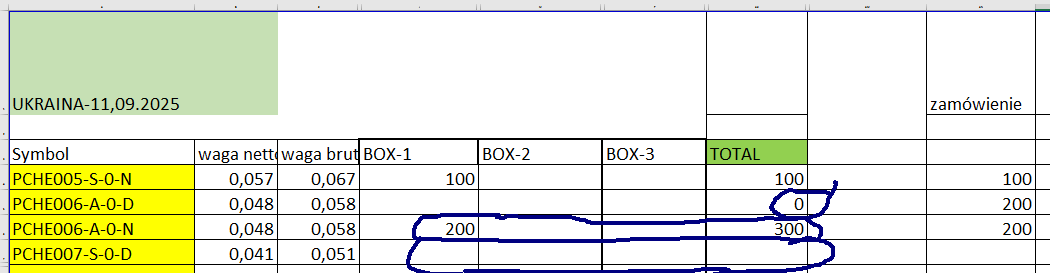
### Файл після очищення:
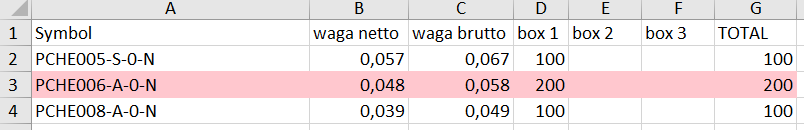
